### Packages

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

from IPython.display import Image
from IPython.core.display import HTML 

Using TensorFlow backend.


# Learning boolean functions
By Jurriaan Parie

#### Introduction
In this project, we create neural networks that learn boolean functions. We start with learning low-dimensional boolean functions (e.g. the logic gates AND, OR, NOT) by perceptrons and show theoretically that every $n$-dimensional boolean function can be represented as a composition of those three logic gates. We show that single sigmoid neurons can approximate those logic perceptrons and, hence, that a network consisting of a colelction of sigmoid neurons can learn higher dimensional boolean function. Based on this theoretical foundation, we create small neural networks in plain numpy and discuss the implementation of hidden layers, gradient descent and dropout. We make those networks more advanced by using Keras to devise multi-layer neural networks.

#### Main question
*What is the highest $n \in \mathbb{N}$ for which we can approximate $n$-dimensional boolean functions 100% accurate using neural networks?*

#### Table of contents
1. Defining a boolean function
2. Neurons as logic operators
3. Neural networks and boolean function
4. Optimization methods
5. Size of the hidden layer and dropout
6. Scaling up in Keras
7. Conclusion
8. Discussion


### 1. Defining a boolean function
We start with defining a *boolean function* as:

$$
\text{a function }f: \{0,1\}^n \to \{0,1\},\text{ for } n \in \mathbb{N}.
$$

A $n$-dimensional boolean function can be represented as $f(x_1,x_2, \ldots, x_n) \in \{0,1\}$, where $x_i \in \{0,1\}$ for all $1 \leq i \leq n$. As an example, $f_1(x_1,x_2)$ respresents $2^{2^2} = 16$ boolean functions since there are 4 combinations to choose $x_1,x_2 \in \{0,1\}$:

$$
f_1(x_1,x_2) = 
\begin{cases}
f(0,0) \in \{0,1\} \\
f(0,1) \in \{0,1\} \\
f(1,0) \in \{0,1\} \\
f(1,1) \in \{0,1\}.
\end{cases}
$$

and there are 4 combinations to choose $f_1(x_1,x_2) \in \{0,1\}$. In general, $f(x_1,x_2, \ldots, x_n)$ represents $2^{2^n}$ boolean functions. 

#### ANDs, NOTs, ORs
ANDs, ORs and NOTs are examples of logic operator. ANDs and ORs and can be represented by two-dimensional boolean functions. NOTs are an example of a one-dimensional boolean function. Those logic operators adhere to the so-called truth tables depicted in Table 1.

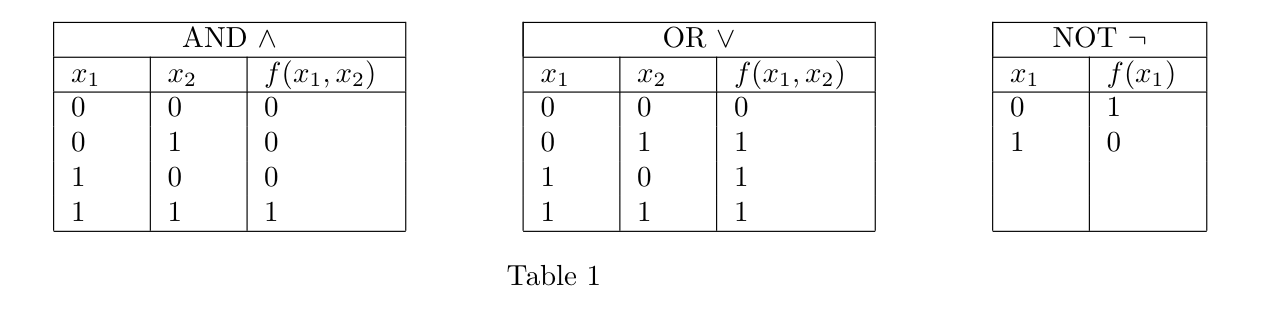

In [54]:
Image(filename = "AND_NOT_OR.png", width = 800)

For the sake simplicity, we denote AND as $\wedge$, OR  as $\vee$ and NOT as $\neg$. 

We claim that every $n$-dimensional boolean function can be realized by the composition of ANDs, ORs and NOTs$^\dagger$. (*Claim 1*)

$^\dagger$ Strictly speaking only ANDs and NOTs are needed to create any $n$-dimensional boolean function but in this claim ORs are welcome too.

Let's consider the boolean function $f_2:\{0,1\}^3 \to \{0,1\}$ that maps $(0,1,0)$ and $(1,1,1)$ to $1$ and all other binary $3$-tuples to $0$. In order to write this boolean function as a composition of boolean expressions, we first focus on the tuples for which the function has value $1$. For each such row, we construct a boolean expression that fix the values of all the row’s inputs. For example, the mapping $(0,1,0) \to 1$ is represented by 

$$
\begin{equation}
\neg (x_1) \wedge (x_2) \wedge \neg (x_3).
\label{eq:bool1}
\tag{1}
\end{equation}
$$

Following the same procedure, for the mapping $(1,1,1) \to 1$ we construct 

$$
\begin{equation}
x_1  \wedge x_2 \wedge x_3.
\label{eq:bool2}
\tag{2}
\end{equation}
$$

Now, if we OR together $\eqref{eq:bool1}$ and $\eqref{eq:bool2}$, $f_2$ can be written as

$$
(\neg (x_1) \wedge (x_2) \wedge \neg (x_3)) \vee (x_1  \wedge x_2 \wedge x_3).
$$

A Boolean function written in this form is called the *canonical representation*. The key insight to understand why Claim 1 holds for all $n \in \mathbb{N}$, is that every $n$-dimensional Boolean function that maps a $n$-tuple to $1$ can be written in this canonical representation. Then, the negations of these canonical map all $n$-tuple to $0.$ Hence, every $n$-dimensional Boolean function can be expressed by ANDs, ORs and NOTs.

In the next section, we show that logic gates (the building blocks of boolean functions) can be modeled by perceptrons.


### 2. Neurons as logic operators
First, we show that ANDs, ORs and NOTs can be modelled by perceptrons. Then, we show that perceptrons can be approximated arbitrarily closely by sigmoid neurons.


#### Perceptrons
In Figure 1, a $n$-input $1$-output perceptron $\hat{f}:\{0,1\}^{n} \in \{0,1\}$ is showed.

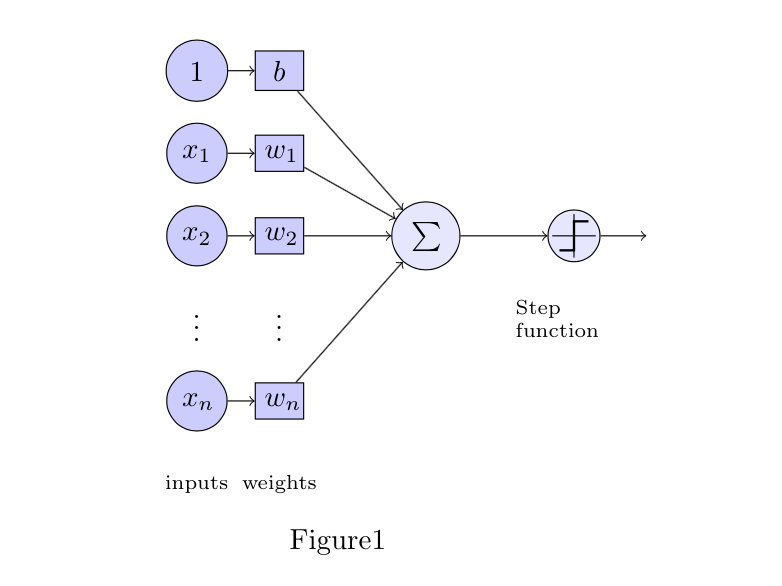

In [45]:
Image(filename = "perceptron.png", width = 500)

As we know, the function value of a perceptron $\hat{f}$ is determined by its input values $x_1, \ldots, x_n$, its weights $w_1, w_2, \ldots w_n$ and its bias term $b$:

$$
\begin{equation}
\hat{y} = \hat{f}(x_1,x_2, \ldots, x_n) =
\begin{cases}
1 \qquad \text{ if } \langle w, x \rangle + b \geq 0 \hspace{4pc} \\
0 \qquad \text{ else,} 
\end{cases}
\label{eq:perceptron}
\tag{3}
\end{equation}
$$

where $\langle w, x \rangle = w^T x =  w_1 x_1 + w_2 x_2 + \ldots + w_n x_n$ is the standard inner product of $w$ and $x$.

Depending on the weights and bias, a perceptron uniquely specifies a function that assigns $1$ to some vertices of a hypercube in $\{0,1\}^n$ and $0$ to the other vertices. We know such functions as *threshold functions*.  In Figure 1, for $n=2$ we depict two perceptrons that act as an AND and OR operator. Depending on its weights and biases the perceptron maps the points on the right (arrow-side) to 1 and the left (non-arrow-side) to 0.

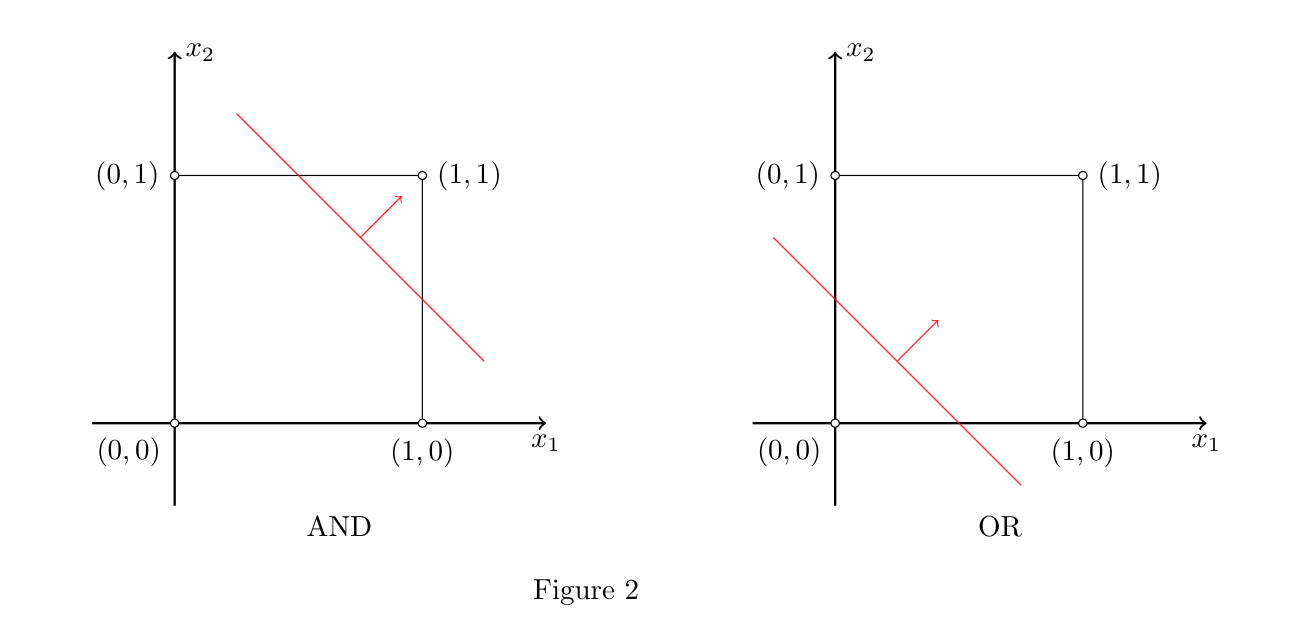

In [42]:
Image(filename = "AND_OR_threshold.png", width = 750)

By learn weights and bias the perceptron can learn to draw the correct red line by following the procedure of *forward-* and *backward propagation* : 
- initialize $w,b$;
- forward propagation;
- determine the error;
- backward propagation and adjust $w,b$;
- repeat this procedure for all training examples.

Due to its rigidity and jumpiness, it turns out that the discontinuous step function $(3)$ is not ideal for learning weights and biases according to the above procedure. So, we replace this rigid step function by its smooth counterpart in the next section.

#### Sigmoid units
The sigmoid function $\sigma: \mathbb{R} \to (0,1)$ can be thought of as a ‘smoothed’ version of the step function $(3)$ and is defined as

$$
\sigma(t) = \frac{1}{1+e^{-ct}},
$$
for $t \in \mathbb{R}$. Three sigmoid for $c=1$, $c=2$ and $c=3$ are given in Figure 3.

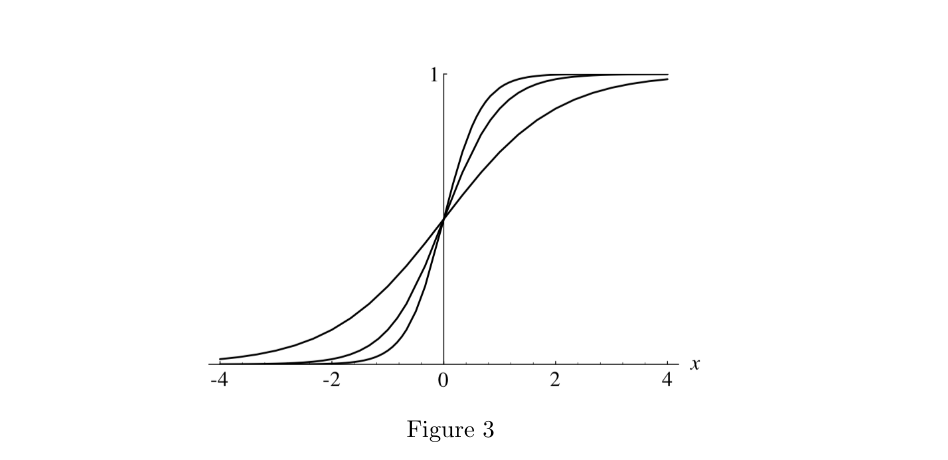

In [47]:
Image(filename = "sigmoid.png", width = 600)

Since $\sigma$ maps $\mathbb{R}$ to the interval $(0,1)$, the function is differentiable and satisfies

$$
\lim_{t \to - \infty} \sigma(t) = 0, \hspace{0.5pc} \lim_{t \to \infty} \sigma(t) = 1.
$$

So, the sigmoid function is a smooth approximation of the step function and it indeed converges pointwise to the so-called [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) as $c \to \infty$. Therefore, a $n$-input sigmoid neuron is just a perceptron whose step function has been replaced by a sigmoid function.

Having introduced different activation functions, we can create different neurons to model AND, NOT and OR logic operators. In the next section, we start implementing neural networks that learn boolean functions.

### 3. Neural networks and boolean function 
In this section, we move from the theoretical part to the practical part of this project. We first create an AND perceptron and then move on to a $3$-dimensional boolean function which is learned by sigmoid neurons. 


#### AND perceptron
As described in section 2, an AND perceptron starts with determining the inner product between the input values and the given weights. These values (corrected according to the bias term) are classified as $1$ if the inner product is greater than $0$ and $0$ otherwise. Note that for multiple input values the inner products can be derived simultaneously by matrix multiplication, i.e. the one-for-one input value approach $\langle x_i, w \rangle$ becomes the all-in-one computation $Xw + b$ where $X$ is the input data matrix, $w$ the weights vector and $1 \leq i \leq n$, where $n$ is the number of input values. 

We implement such an AND perceptron below. We start with defining the AND input data in numpy.

In [2]:
X = np.array([  [0,0],
                [0,1],
                [1,0],
                [1,1] ])

And we define two options for initial weights vector $w$.

In [3]:
# option1: weights and bias
w1 = [1, 1]
b1 = -1.5

# option2: weights and bias
w2 = [-1, 2]
b2 = 1

Then, we define $Xw + b$ for both options.

In [4]:
# Wx + b
mat1 = np.dot(X,w1) + b1
mat2 = np.dot(X,w2) + b2

And classify the input values according to the step function.

In [5]:
# step function
est1 = [0 if x < 0 else 1 for x in mat1]
est2 = [0 if x < 0 else 1 for x in mat2]

The result yields:

In [6]:
print("Perceptron with weight:",w1, "and bias:", b1, "returns:", est1)
print("Perceptron with weight:",w2, "and bias:", b2, "returns:", est2)

Perceptron with weight: [1, 1] and bias: -1.5 returns: [0, 0, 0, 1]
Perceptron with weight: [-1, 2] and bias: 1 returns: [1, 1, 1, 1]


Note that the perceptron classifies all input data correctly for option 1 (```w1 = [1,1], b1 = -1.5```), but incorrectly for option 2 (```w2 = [-1,2], b2 = 1```). In the next example, we illustrate how we learn to assign the correct weights and bias terms to learn the mapping rules of a boolean function.

#### Learning a 3-dimensional boolean function using sigmoid neurons
In this section, we aim to learn the $3$-dimensional boolean function $f_3$ which truth table is defined in Table 2. In doing so, we use sigmoid neurons that make use of backpropagation to learn (non-unique) weights that map the input data correctly to the desired output data ($f_3$).

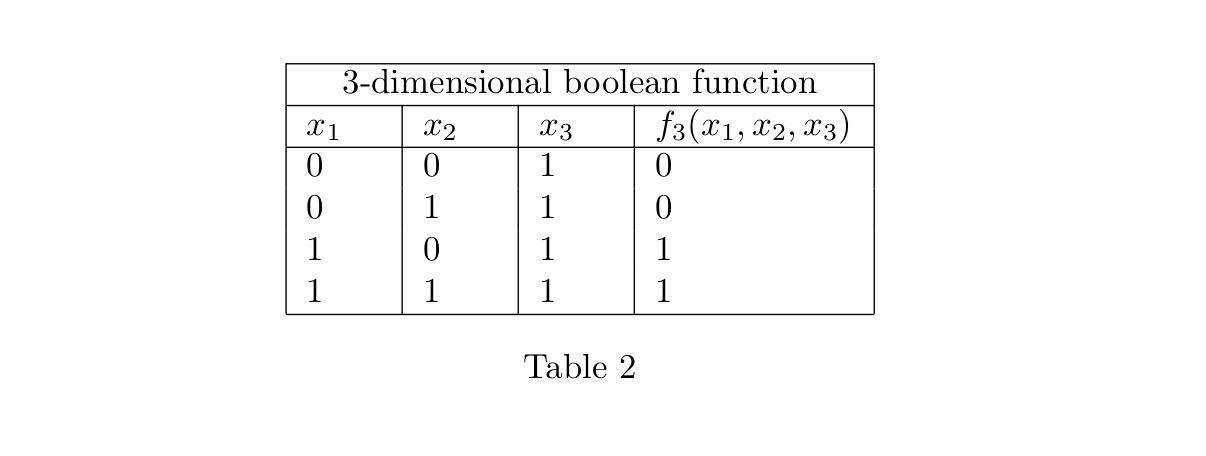

In [7]:
Image(filename = "3_dim_boolean.png", width = 750)

Note that in the above truth table $x_1$ is perfectly correlated with $f(x_1,x_2,x_3)$. Backpropagation exploits this statistic to find weights that model $f_3$. Before we elaborate on how this exaclty works, we first define the input data $X$ and desired output data $f_3 = y$.

In [8]:
# input data
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])
    
# output data            
y = np.array([[0,0,1,1]]).T

This time we initialize the weights vector randomly with mean 0 and exclude a bias term for now ($b = 0$).

In [9]:
np.random.seed(4)

# initial weights
w = 2*np.random.random((3,1)) - 1
w

array([[0.93405968],
       [0.0944645 ],
       [0.94536872]])

We repeat the backpropagation procedure $1000$ times to learn weights that model the $3$-dimensional boolean function $f_3$. We use backpropagation that makes use of the so-called *error weighted derivative*. The key insight about this method is that due to the shape of the sigmoid function (and its derivative) the error of high confidence predictions are reduced and the error of low confidence predictions is increased. The procedure states that:

1. initialzie $w$;
2. forward propagation: $\hat{y} = \sigma(Xw)$;
3. determine the error: $err = | y - \hat{y} |$; 
4. find the error weighted derivative $\delta$, i.e. multiply the sigmoid slope by the error: $\delta = err \cdot \sigma'(\hat{y})$;
5. find the new adjusted weights $w'$ by updating the old weights: $w' = w + \langle X^T, \delta \rangle$.

For this reason, we define a sigmoid function (with $c=1$) and its derivative in one function.

In [6]:
def sigm(x, derivative = False):
    if(derivative == True):
        return(x*(1-x))
    else:
        return(1/(1 + np.exp(-x)))

We repeat backpropagation $1000$ times such that the weights hopefully 'converge' within those iteration. We show the value of the weights every 200th iteration.

In [13]:
for i in range(1001):
    if i % 200 == 0:
        print("iteration", i, ", weights:\n", w)
        
    else:
        # forward propagation
        sigm_neuron = sigm(np.dot(X,w))

        # error
        error = y - sigm_neuron

        # error weighted derivative for value in sigmoid neuron
        delta = error * sigm(sigm_neuron, derivative = True)

        # update weights
        w += np.dot(X.T, delta)

iteration 0 , weights:
 [[ 7.99707363]
 [-0.21729647]
 [-3.78460143]]
iteration 200 , weights:
 [[ 8.09759777]
 [-0.21652815]
 [-3.83544696]]
iteration 400 , weights:
 [[ 8.18915064]
 [-0.21586442]
 [-3.88172779]]
iteration 600 , weights:
 [[ 8.2731951 ]
 [-0.21528385]
 [-3.92419152]]
iteration 800 , weights:
 [[ 8.35086386]
 [-0.21477066]
 [-3.96341639]]
iteration 1000 , weights:
 [[ 8.42305177]
 [-0.21431294]
 [-3.99985885]]


The weights of the sigmoid neuron after $1000$ iterations are ```w_1 = 8.42, w_2 = -0.21, w_3 = -3.99```. Based on these weights the sigmoid neuron's estimate of the output data is:

In [14]:
sigm_neuron

array([[0.01799183],
       [0.01457167],
       [0.98814429],
       [0.98535213]])

Which approximates our output data $y$ very well!

Due to the one-to-one relationship between $x_1$ and $f(x_1,x_2,x_3)$, the boolean function $f_3$ in Table 2 can be learned easily by a single sigmoid neuron. However, when a 'non-linear' pattern appears in a boolean function we need an extra layer of neurons to learn the output data.

#### Multi-layer neural networks and dropout

An example of a $3$-dimensional boolean function $f_4$ with a 'non-linear' pattern is given in Table 3.

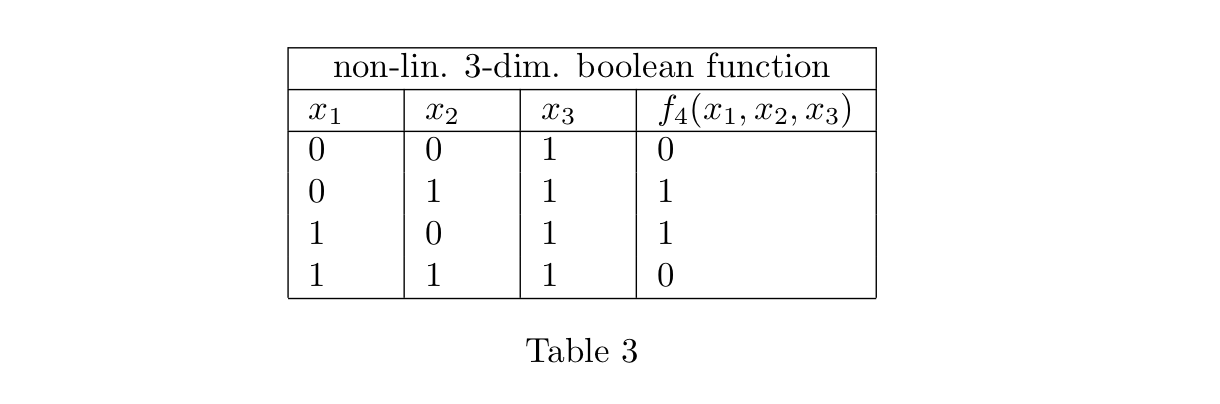

In [49]:
Image(filename = "3_dim_boolean_non_lin.png", width = 750)

We see that there does not exist an one-to-one relationship between either $x_1, x_2$ or $x_3$ and $f(x_1,x_2,x_3)$. Instead, there exists an one-to-one relationship between $(x_1,x_2)$ and $f(x_1,x_2,x_3)$. Note that $f_4$ is an extension of the [XOR](https://en.wikipedia.org/wiki/XOR_gate)-problem. In order to learn this relationship, we have to add an extra (hidden) layer of sigmoid neurons to the network. An example of such a multi layer network is given in Figure 4.

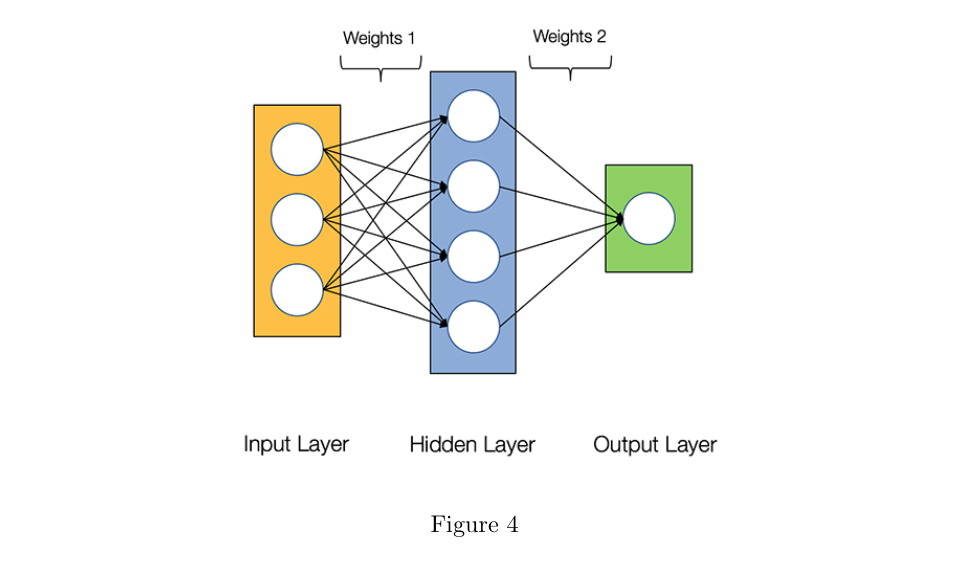

In [51]:
Image(filename = "multi_layer.png", width = 600)

Note that Figure 4 is taken from [here](https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6).

In this multi-layer network, the first set of weights ('Weights 1' in Figure 4) is now given by a $3 \times 4$ matrix and the second set of weights ('Weights 2' in Figure 4) is given by a $4 \times 1$ vector. 

We start with defining the input and desired output data of $f_4$.

In [4]:
# input dataset
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])
    
# output dataset            
y = np.array([[0,1,1,0]]).T

Now, we initialize the $3 \times 4$ weight matrix and the $4 \times 1$ weight vector (randomly with mean 0). Again, we do not incorporate a bais term ($b = 0$).

In [4]:
W1 = 2*np.random.random((3,4)) - 1
w2 = 2*np.random.random((4,1)) - 1

Now, we repeat the process of backpropagation using the error weighted derivative $10.000$ times. This time, the procedure through the extra layer with 4 sigmoid neurons follows the steps:
1. initialize weight matrix $W_1$ and weight vector $w_2$;
2. forward propagation: $\hat{y} = \sigma( \sigma(XW_1) w_2)$;
3. determine the error between the sigmoid neuron in the output layer: $err_2 = |y−\hat{y}|$;
4. find the error weighted derivative $\delta_2 = err_2 \cdot \sigma'(\hat{y})$ for the sigmoid neuron in the output layer;
5. determine the 'confidence weighted error' $err_1$ in the hidden layer by $err_1 = \langle \delta_2, w_2 \rangle$;
6. find the error weighted derivative $\delta_1 = err_1 \cdot \sigma'(\sigma(XW_1))$ for the sigmoid neurons in the hidden layer;
7. find the new adjusted weights $w_2'$ by updating the old weights vector: $w_2' = w_2 + \langle \sigma(XW_1), \delta_2 \rangle$;
8. find the new adjusted weights $W_1'$ by updating the old weights matrix: $W_1' = W_1 + \langle X^T, \delta_1 \rangle$.

We repeat this procedure $10.000$ times and we print the $err_2$ every 1000th iteration.

In [5]:
for i in range(10000):

    # forward propagation
    sigm_l1 = sigm(np.dot(X,W1))
    sigm_l2 = sigm(np.dot(sigm_l1,w2))

    # error
    l2_error = y - sigm_l2

    # print error
    if (i% 1000) == 0:
        print("iteration", i, ", error:", np.mean(np.abs(l2_error)))

    # error weighted derivative for value in sigm_l2
    l2_delta = l2_error * sigm(sigm_l2, derivative = True)

    # how much did each l1 value contribute to the l2 error
    l1_error = l2_delta.dot(w2.T)

    # error weighted derivative for value in sigm_l1
    l1_delta = l1_error * sigm(sigm_l1, derivative = True)

    # adjust weights
    w2 += sigm_l1.T.dot(l2_delta)
    W1 += X.T.dot(l1_delta)

iteration 0 , error: 0.4995152677167336
iteration 1000 , error: 0.03977640387576131
iteration 2000 , error: 0.02311326794364927
iteration 3000 , error: 0.017594834448082804
iteration 4000 , error: 0.01466645582006628
iteration 5000 , error: 0.012796597946686658
iteration 6000 , error: 0.011476045179816943
iteration 7000 , error: 0.010482101504586196
iteration 8000 , error: 0.00970036707144219
iteration 9000 , error: 0.00906542226707344


We see that the error decreases monotonically after every $1000$th iteration. When the $10.000$ iterations are completed, the weights have become:

In [17]:
print("W1 matrix:\n", W1)
print("w2 vector:\n", w2)

W1 matrix:
 [[ 3.38512708  3.89789626 -4.98095478 -5.74995404]
 [ 2.99093243 -5.45167181  3.02277458 -6.0273861 ]
 [-4.81380541 -1.82892738 -1.12976806  2.14784378]]
w2 vector:
 [[-6.18909663]
 [ 6.97406487]
 [ 6.57887402]
 [-8.37185845]]


And the neural network estimates the output data as:

In [18]:
sigm_l2

array([[0.00686154],
       [0.9909161 ],
       [0.99173842],
       [0.00994238]])

Which approximates $y$ very well!

The examples in the preceding section showed us forward- and backward propagation in simple neural networks. We measured how each weight in the network contributed to the overall error and adjusted those weights to fit our data better by using the error weighted derivative. We explore more of such optimization methods in the next section.


### 4. Optimization methods
In this section, we implement the Gradient Descent optimization method in the above backpropagation code to make our neural networks more effective. On top of that, we discuss the task of choosing a correct learning rate.  

#### Gradient descent
In a neural network, we aim to minimize the error of the value estimation with respect to the weights in the network. 
A well-know method to achieve this is Gradient Descent. For given weights in the network, the Gradient Descent method follows the steps: 

- detrmine the gradient of the error function with respect to the given weights;
- change the weights by the negative of the gradient scaled by a tuning parameter $\alpha$;
- repeat this proces until the gradient is 0.

The tuning parameter $\alpha$ is introduced to deal with the weaknesses of the Gradient Descent method: overcompensation of steep slopes, undercompensation of shallow slopes and a tool to break out of local minima of the error function. In other words, $\alpha$ helps to increase or to decrease the magnitude of each iteration's weights update. Learning and tuning the value of $\alpha$ is an important task of making a neural network accurate and effective.

In order to understand the effect of $\alpha$ on the accuracy of our neural networks better, we return to the task of learning the $3$-dimensional boolean function $f_4$ and implement the Gradient Descent method for a grid of $\alpha$'s.

In [4]:
alphas = [0.001,0.01,0.1,1,10,100,1000]

Then, we modify the code about the error weighted derivative to implement the Gradient Descent method. We create a for loop that iterates through all 7 values for $\alpha$. In this for loop, we repeat the process of forward and backward propagation $50.000$ times. This time, according to the Gradient Descent method, at the end of every iteration we change the weights by the negative of the slope (gradient) scaled by alpha. So, the new weights update is given by:

- $w_2' = w_2 - \alpha \cdot \langle \sigma(XW_1), \delta_2 \rangle$;
- $W_1' = W_1 - \alpha \cdot \langle X^T, \delta_1 \rangle$.

The adjusted code is given below and we print for every $\alpha$ each $10.000$th iteration the error of the estimate by the neural network.

In [80]:
for alpha in alphas:
    print("\nAlpha:", alpha)
    np.random.seed(1)

    # randomly initialize our weights with mean 0
    W1 = 2*np.random.random((3,4)) - 1
    w2 = 2*np.random.random((4,1)) - 1

    for i in range(50001):

        # Feed forward through layers 0, 1, and 2
        sigm_l1 = sigm(np.dot(X,W1))
        sigm_l2 = sigm(np.dot(sigm_l1,w2))

        # how much did we miss the target value?
        l2_error = sigm_l2 - y

        if (i % 10000) == 0:
            print("iteration", i, ", error:", np.mean(np.abs(l2_error)))

        # error weighted derivative for value in sigm_l2
        l2_delta = l2_error * sigm(sigm_l2, derivative = True)

        # how much did each l1 value contribute to the l2 error (according to the weights)?
        l1_error = l2_delta.dot(w2.T)

        # error weighted derivative for value in sigm_l1
        l1_delta = l1_error * sigm(sigm_l1, derivative = True)
        
        W1 -= alpha * (X.T.dot(l1_delta))
        w2 -= alpha * (sigm_l1.T.dot(l2_delta))


Training With Alpha:0.001
iteration 0 , error: 0.49641003190272537
iteration 10000 , error: 0.49516402549338606
iteration 20000 , error: 0.4935960431880486
iteration 30000 , error: 0.4916063585594306
iteration 40000 , error: 0.48910016654420474
iteration 50000 , error: 0.48597785784615843

Training With Alpha:0.01
iteration 0 , error: 0.49641003190272537
iteration 10000 , error: 0.45743107444190134
iteration 20000 , error: 0.35909720256339894
iteration 30000 , error: 0.2393581371589725
iteration 40000 , error: 0.14307065901337035
iteration 50000 , error: 0.09859642980892715

Training With Alpha:0.1
iteration 0 , error: 0.49641003190272537
iteration 10000 , error: 0.0428880170001158
iteration 20000 , error: 0.024098994228521613
iteration 30000 , error: 0.018110652146797846
iteration 40000 , error: 0.01498761627221092
iteration 50000 , error: 0.013014490538142583

Training With Alpha:1
iteration 0 , error: 0.49641003190272537
iteration 10000 , error: 0.008584525653247153
iteration 20000

We see a variety of errors for the 7 different values of $\alpha$. What do we observe?

- $\alpha = 0.001$: the error value decreases only a little bit. Clearly, the weight updates are far too small to converge in $50.000$ iterations. This is a typical example of a shallow slope (and small gradients) on which the 'steps' or 'learning rate' (the magnitude of the weight updates) are too small to find a (local) minimum within the $50.000$ iterations. Hence, $\alpha$ should be increased;


- $\alpha = 0.01$: for this bigger $\alpha$ we already see better convergence towards a $0$ error value. However, the rate of convergence and the accuracy could be increased;


- $\alpha = 0.1$: we start to see nice convergence but convergence slows down after a while, this still indicates shallow slopes and small gradients;


- $\alpha = 1$: rate of convergence and accuracy start look very okay;


- $\alpha = 10$: we get the most accurate results for this value of $\alpha$. Note that after $10.000$ iterations we already have found the most accurate network. The fact that $\alpha > 1$ tells us that our weight updates were being too conservative for smaller alpha's: the weights were heading in the right direction but they simply did not had enough time to find a (local) minimum within $50.000$ iterations;


- $\alpha = 100$: this is a textbook example of a value for $\alpha$ that is too large. We jump around the error plane too enthousiastically and end up in an inaccurate and deep local minimum.


- $\alpha = 1000$: for this extreme big $\alpha$ the error value does not decrease but increase to $0.5$. This means that we are going back and forth in the error plane far too wildly and never settle in any (local) minimum.

Now we have seen the importance of choosing a reasonable $\alpha$, we want to gain more insight how to choose $\alpha$ effectively.


#### Tuning $\alpha$
In order to build effective neural networks based on Gradient Descent, we have seen that finding a reasonable $\alpha$ plays a vital role. One way of getting a better understanding of choosing $\alpha$ is to look at the number of times a derivative changed direction during training. Since a change in direction signifies that the optimization methods passed over a (local) minimum. Similarly, no changes of direction indicate that the minimum could not be reached within the given iterations, but the optimization moves into the right direction. Keeping track of those direction changes gives us more insight about the effectiveness of $\alpha$. 

We can implement such a direction change track record quite easily in the above Gradient Descent code. In order to do so, we store the weight updates before they get scaled by $\alpha$. Then, we count a change in sign for every individual weight in $W1$ and $w2$. We keep track of this for $50.000$ iterations and print the final error, final weights and corresponding amount of direction changes.

In [10]:
for alpha in alphas:
    print("\nAlpha:", alpha)
    np.random.seed(1)

    # randomly initialize our weights with mean 0
    W1 = 2*np.random.random((3,4)) - 1
    w2 = 2*np.random.random((4,1)) - 1
    
    # initialize lists for direction change count
    prev_W1_upd = np.zeros_like(W1)
    prev_w2_upd = np.zeros_like(w2)
    
    W1_change_count = np.zeros_like(W1)
    w2_change_count = np.zeros_like(w2)

    for i in range(50001):

        # Feed forward through layers 0, 1, and 2
        sigm_l1 = sigm(np.dot(X,W1))
        sigm_l2 = sigm(np.dot(sigm_l1,w2))

        # how much did we miss the target value?
        l2_error = sigm_l2 - y

        if (i % 50000) == 0 and i !=0:
            print("final error:", np.mean(np.abs(l2_error)))

        # error weighted derivative for value in sigm_l2
        l2_delta = l2_error * sigm(sigm_l2, derivative = True)

        # how much did each l1 value contribute to the l2 error (according to the weights)?
        l1_error = l2_delta.dot(w2.T)

        # error weighted derivative for value in sigm_l1
        l1_delta = l1_error * sigm(sigm_l1, derivative = True)
        
        W1_upd = X.T.dot(l1_delta)
        w2_upd = sigm_l1.T.dot(l2_delta)
        
        if(i > 0):
            W1_change_count += np.abs(((W1_upd > 0)+0) - ((prev_W1_upd > 0) + 0))
            w2_change_count += np.abs(((w2_upd > 0)+0) - ((prev_w2_upd > 0) + 0))        

        W1 -= alpha * W1_upd      
        w2 -= alpha * w2_upd
        
        prev_W1_upd = W1_upd
        prev_w2_upd = w2_upd
        
    print("W1 matrix:\n", W1)
    print("W1 direction changes:\n", W1_change_count)
    
    print("w2 vector:\n", w2)
    print("w2 direction changes:\n", w2_change_count)


Alpha: 0.001
final error: 0.48597785784615843
W1 matrix:
 [[-0.26369635  0.33077206 -1.41065483 -0.4587672 ]
 [-0.74627175 -1.00111343 -1.29387012 -0.3203843 ]
 [-0.24649768 -0.10465307 -0.30166387  0.39360958]]
W1 direction changes:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 1.]]
w2 vector:
 [[-0.62191689]
 [ 0.74517324]
 [-1.35791938]
 [ 0.38562034]]
w2 direction changes:
 [[1.]
 [1.]
 [0.]
 [1.]]

Alpha: 0.01
final error: 0.09859642980892715
W1 matrix:
 [[ 2.12689162  2.35642454 -5.25614438 -3.2159392 ]
 [-0.17885696 -4.48416517 -5.53647306 -1.50259569]
 [-0.17304462 -1.03465415  1.88239622  3.13554943]]
W1 direction changes:
 [[1. 1. 0. 0.]
 [2. 0. 0. 2.]
 [4. 2. 1. 1.]]
w2 vector:
 [[-3.35004501]
 [ 4.29230235]
 [-7.28981422]
 [ 4.43687426]]
w2 direction changes:
 [[2.]
 [1.]
 [0.]
 [1.]]

Alpha: 0.1
final error: 0.013014490538142583
W1 matrix:
 [[ 3.8083666   3.5881893  -5.96582211 -3.78979191]
 [-1.64426752 -5.37866015 -6.27830983 -2.97729043]
 [ 0.413488   -1.74791409  2.356954

What do we observe from the above direction changes?

We see that:


- for small $\alpha$ there are almost no direction changes, this echoes the view that the optimization is going into the right direction but is not moving fast enough. Hence, to find a (local) minimum in $50.000$ iterations $\alpha$ needs to be increased. Besides that, the final weights tend to be small. ;


- for the optimal $\alpha$ the sign of the gradient changes a lot. This signifies the movement back and forth over the (local) minimum;


- for large $\alpha$ the signs change a medium amount. The final weights tend to become large too.


We conclude that keeping track of the direction changes provides us with useful information about selecting a reasonable value for $\alpha$. More ways to make our neural networks more accurate and efficient are discussed in the next section.

### 5. Size of the hidden layer and dropout
To make neural networks more accurate we can increase the amount of neurons in the hidden layer. To make neural networks more efficient we introduce dropout that randomly sets nodes off during forward propagation. We discuss both concepts in this section.

#### Increase the amount of neurons in the hidden layer
By increasing the amount of neurons in the hidden layer, we increase the search space the neural network is going through to find (local) minima. In doing so, the network might converge faster and more accurately. We can increase the size of the hidden layer easily in the above Gradient Descent code that iterates over the grid of $\alpha$'s to $32$. Note that the dimensions of the weight matrix $W_1$ change to $3 \times 32$ and the dimensions of the weight vector change to $32 \times 1$.

In [17]:
hidden_nodes = 32

for alpha in alphas:
    print("\nAlpha:", alpha)
    np.random.seed(1)

    # randomly initialize our weights with mean 0
    W1 = 2*np.random.random((3,hidden_nodes)) - 1
    w2 = 2*np.random.random((hidden_nodes,1)) - 1

    for i in range(50001):

        # Feed forward through layers 0, 1, and 2
        sigm_l1 = sigm(np.dot(X,W1))
        sigm_l2 = sigm(np.dot(sigm_l1,w2))

        # how much did we miss the target value?
        l2_error = sigm_l2 - y

        if (i % 10000) == 0:
            print("iteration", i, ", error:", np.mean(np.abs(l2_error)))

        # error weighted derivative for value in sigm_l2
        l2_delta = l2_error * sigm(sigm_l2, derivative = True)

        # how much did each l1 value contribute to the l2 error (according to the weights)?
        l1_error = l2_delta.dot(w2.T)

        # error weighted derivative for value in sigm_l1
        l1_delta = l1_error * sigm(sigm_l1, derivative = True)
        
        W1 -= alpha * (X.T.dot(l1_delta))
        w2 -= alpha * (sigm_l1.T.dot(l2_delta))


Alpha: 0.001
iteration 0 , error: 0.49643992250078794
iteration 10000 , error: 0.4910494681290495
iteration 20000 , error: 0.48497630702745964
iteration 30000 , error: 0.47783067879265556
iteration 40000 , error: 0.4690384653902826
iteration 50000 , error: 0.4580292585652751

Alpha: 0.01
iteration 0 , error: 0.49643992250078794
iteration 10000 , error: 0.3563790616480214
iteration 20000 , error: 0.14693984546475997
iteration 30000 , error: 0.08801561274158763
iteration 40000 , error: 0.06514781927504909
iteration 50000 , error: 0.052965808702569686

Alpha: 0.1
iteration 0 , error: 0.49643992250078794
iteration 10000 , error: 0.03054049083855504
iteration 20000 , error: 0.019063872533418427
iteration 30000 , error: 0.014764390729581748
iteration 40000 , error: 0.0123892429904713
iteration 50000 , error: 0.010842166973777429

Alpha: 1
iteration 0 , error: 0.49643992250078794
iteration 10000 , error: 0.007360522342493729
iteration 20000 , error: 0.004972517050388167
iteration 30000 , err

We see that the neural network with $32$ nodes in the hidden layer is more accurate for $\alpha = 10$ than the network with $4$ hidden nodes. The network with $4$ hidden nodes achieves $0.0013$ accuracy, where the network with 32 nodes achieves $0.0009$ accuracy. The difference might look marginal, but the affect starts to play a big role in modeling larger datasets.

Another method to make neural networks more efficient (not necessarily more accurate) is dropout.

#### Dropout
By setting some nodes in a layer of the network randomly to zero during forward propagation, dropout helps to prevent weights from converging to identical positions. The interplay between an increasing amount of nodes in the hidden layer and dropout makes a neural network more efficient. In doing so, the amount of values being propagated forward needs to be increased in proportion to the number of values being turned off. We can implement dropout quite easily in the above Gradient Descent code for $\alpha = 1$ with a dropout rate of $20\%$. 

In [13]:
alpha = 1
hidden_nodes = 32
dropout_rate = 0.2

np.random.seed(1)

# randomly initialize our weights with mean 0
W1 = 2*np.random.random((3,hidden_nodes)) - 1
w2 = 2*np.random.random((hidden_nodes,1)) - 1

for i in range(50001):

    # feed forward layer 0 -> 1
    sigm_l1 = sigm(np.dot(X,W1))
    
    # dropout hidden layer (layer 1)
    sigm_l1 *= np.random.binomial([np.ones((len(X),hidden_nodes))],1 - dropout_rate)[0] * (1.0/(1 - dropout_rate))
    
    # feed forward layer 1 -> 2
    sigm_l2 = sigm(np.dot(sigm_l1,w2))

    # how much did we miss the target value?
    l2_error = sigm_l2 - y

    if (i % 10000) == 0:
        print("iteration", i, ", error:", np.mean(np.abs(l2_error)))

    # error weighted derivative for value in sigm_l2
    l2_delta = l2_error * sigm(sigm_l2, derivative = True)

    # how much did each l1 value contribute to the l2 error (according to the weights)?
    l1_error = l2_delta.dot(w2.T)

    # error weighted derivative for value in sigm_l1
    l1_delta = l1_error * sigm(sigm_l1, derivative = True)

    W1 -= alpha * (X.T.dot(l1_delta))
    w2 -= alpha * (sigm_l1.T.dot(l2_delta))

iteration 0 , error: 0.525447419874109
iteration 10000 , error: 0.0020265963589760076
iteration 20000 , error: 3.9181809617617065e-05
iteration 30000 , error: 8.536563860928323e-05
iteration 40000 , error: 0.008723686188812583
iteration 50000 , error: 0.001488022514964101


We see that the error rate reaches a new low at the $20.000$th iteration. However, after the $20.000$th iteration the error rate increases again. We recall that dropout is not necessarily contributing to the accuracy of the neural network but particularly makes the neural network more efficient by preventing nodes to converge to the same 'position'. Therefore, the effect of dropout becomes better visible in larger networks that aim to model larger and more complex datasets. A common practice is to first increase the amount of nodes in the hidden layer with dropout turned off until the network perfectly fits the data. Then, we train the network (with the same configuration) with dropout turned on. This should yield optimal network efficiency.

Coding neural networks in plain numpy code is great for understanding underlying techniques. However, all of the above methods are implemented much more effectively and elegantly than we did. Therefore, we forego numpy code and embrace Keras to learn higher dimensional boolean functions. 

### 6. Scaling up in Keras
Previously, we have seen boolean functions up to $n=3$. Those function could be learned easily by simple neural networks which we could be created quite easily in plain numpy code. However, when $n$ gets larger, coding advanced neural network in plain numpy code becomes a tedious job. Therefore, in this section we embrace Keras to build neural networks for $n$-dimensional boolean function more easily.

We start with learning the $3$-dimensional boolean function $f_4$ with a neural network in Keras.

#### $3$-dimensional boolean
First, we specify the network architecture. The below network mimics Figure 4: the network consists of one hidden layer with 4 sigmoid neurons and one output layer with one sigmoid neuron. 

In [6]:
# network architecture
f3 = Sequential()
f3.add(Dense(4, activation='sigmoid', input_dim = 3))
f3.add(Dense(1, activation='sigmoid'))

We choose the learning rate (or $\alpha$) to be 10 and optimize the error function according to the (stochastic) gradient descent method.

In [7]:
# configures the model for training
sgd = SGD(lr = 10)
f3.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
f3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 16        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


We train the model over 5.000 epoches on the above defined truth tabel of $f_4$ and corresponding output data .

In [9]:
f3.fit(X, y, epochs = 5000, verbose = 0)
cost, acc = f3.evaluate(X, y, verbose = 0)
print(f'cost: {cost}, acc: {acc * 100}%')
print(f3.predict(X))

cost: 9.434210369363427e-05, acc: 100.0%
[[5.355084e-06]
 [9.999156e-01]
 [9.999161e-01]
 [2.036620e-04]]


The result is a 100% accurate neural network! Before we continue with creating neural networks for $n>3$, we devise a boolean function truth table and value function data generator.

#### $n$-dimensional boolean function generator
In order to learn $n$-dimensional boolean function, we create a function ```boolean_func``` that generates the input data (truth table) and corresponding output data. The below function lists all $2^n$ rows of the truth table and assign to every row randomly $0$ of $1$ such that overall the amount of $0$'s equals the amount of $1$'s in the output vector .

In [2]:
import itertools
import random

## input variables:
#    - n: number of variables

## output variables
#    - X: truth table
#    - y: value function

def boolean_func(n):
    
    # truth table
    X = list(itertools.product([0, 1], repeat = n))
    X = np.array(X)
    len_X = len(X)
   
    # value function
    y = int(len_X/2) * [0] + int(len_X/2) * [1]
    random.shuffle(y)
    y = np.array(y)

    return(X,y)

We use this function to learn a $4$-dimensional boolean function.

#### $4$-dimensional boolean function
We generate the truth table and corresponding output data using the above ```boolean_func```.

In [5]:
X_4, y_4 = boolean_func(4)
print(X_4.shape)
print(y_4.shape)
X_4, y_4

(16, 4)
(16,)


(array([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
        [0, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 1, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0],
        [1, 1, 1, 1]]),
 array([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1]))

We choose the network architecture, optimization configurations and training parameters to be similar as for $n=3$.

In [11]:
# network architecture
f4 = Sequential()
f4.add(Dense(4, activation='sigmoid', input_dim = 4))
f4.add(Dense(1, activation='sigmoid'))

# configures the model for training
sgd = SGD(lr = 1)
f4.compile(loss = 'binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
f4.summary()

# training
f4.fit(X_4, y_4, epochs = 5000, verbose = 0)
cost, acc = f4.evaluate(X_4, y_4, verbose = 0)
print(f'cost: {cost}, acc: {acc * 100}%')
print(f4.predict(X_4))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
cost: 0.003450249321758747, acc: 100.0%
[[9.9835867e-01]
 [3.6014616e-03]
 [4.6443939e-03]
 [1.5798807e-03]
 [9.9963379e-01]
 [4.8136711e-03]
 [9.9838734e-01]
 [9.9464375e-01]
 [6.4745843e-03]
 [9.9268365e-01]
 [9.9676174e-01]
 [9.9748945e-01]
 [9.9546659e-01]
 [8.8515878e-04]
 [2.4747252e-03]
 [4.0295124e-03]]


Which yields directly a 100% accurate network. We continue with $n=5$.

#### $5$-dimensional boolean function

We generate the truth table and corresponding output data using the above ```boolean_func```.

In [7]:
X_5, y_5 = boolean_func(5)

We choose the network architecture, optimization configurations and training parameters to be similar as for $n=3,4$.

In [8]:
# network architecture
f5 = Sequential()
f5.add(Dense(4, activation='sigmoid', input_dim = 5))
f5.add(Dense(1, activation='sigmoid'))

# configures the model for training
sgd = SGD(lr = 1)
f5.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
f5.summary()

# training
f5.fit(X_5, y_5, epochs = 5000, verbose = 0)
cost, acc = f5.evaluate(X_5, y_5, verbose = 0)
print(f'cost: {cost}, acc: {acc * 100}%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
cost: 0.005712432786822319, acc: 100.0%


Which again turns out to be a 100% accuracte network. We continue with $n=6$.

#### $6$-dimensional boolean function
We generate the truth table and corresponding output data using the above ```boolean_func```.

In [51]:
X_6, y_6 = boolean_func(6)

We choose the network architecture, optimization configurations and training parameters to be similar as for $n=3,4,5$.

In [16]:
# network architecture
f6 = Sequential()
f6.add(Dense(4, activation = 'sigmoid', input_dim = 6))
f6.add(Dense(1, activation = 'sigmoid'))

# configures the model for training
sgd = SGD(lr = 1)
f6.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
f6.summary()

# training
f6.fit(X_6, y_6, epochs = 5000, verbose = 0)
cost, acc = f6.evaluate(X_6, y_6, verbose = 0)
print(f'cost: {cost}, acc: {acc * 100}%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 5         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
cost: 0.104588083922863, acc: 93.75%


Interesting! We do not get anymore 100% accuracy straight-away. Since 93.75% is pretty accurate, let's see what happens if we enlarge the number of epoches we train on.

In [18]:
# network architecture
f6 = Sequential()
f6.add(Dense(4, activation = 'sigmoid', input_dim = 6))
f6.add(Dense(1, activation = 'sigmoid'))

# configures the model for training
sgd = SGD(lr = 1)
f6.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
f6.summary()

# training
f6.fit(X_6, y_6, epochs = 10000, verbose = 0)
cost, acc = f6.evaluate(X_6, y_6, verbose = 0)
print(f'cost: {cost}, acc: {acc * 100}%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 5         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
cost: 0.08289286866784096, acc: 96.875%


Better, but not 100% yet. What happens if we range through the learning rate $0.1 \leq \alpha \leq 5.1$ with equidistant stepsize 0.5 for 5.000 epoches?

In [33]:
alphas = np.linspace(0.1,5.1,11)

for alpha in alphas:
    print("alpha:", alpha)
    
    # network architecture
    f6 = Sequential()
    f6.add(Dense(4, activation = 'sigmoid', input_dim = 6))
    f6.add(Dense(1, activation = 'sigmoid'))

    # configures the model for training
    sgd = SGD(lr = alpha)
    f6.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])

    # training
    f6.fit(X_6, y_6, epochs = 5000, verbose = 0)
    cost, acc = f6.evaluate(X_6, y_6, verbose = 0)
    print(f'cost: {cost}, acc: {acc * 100}%')

alpha: 0.1
cost: 0.4998238831758499, acc: 76.5625%
alpha: 0.6
cost: 0.1542266495525837, acc: 98.4375%
alpha: 1.1
cost: 0.18402684479951859, acc: 90.625%
alpha: 1.6
cost: 0.13263331726193428, acc: 95.3125%
alpha: 2.1
cost: 0.10155872534960508, acc: 93.75%
alpha: 2.6
cost: 0.16857818886637688, acc: 92.1875%
alpha: 3.1
cost: 0.242060124874115, acc: 82.8125%
alpha: 3.6
cost: 0.16581257805228233, acc: 93.75%
alpha: 4.1
cost: 0.17365477234125137, acc: 93.75%
alpha: 4.6
cost: 0.1854955181479454, acc: 82.8125%
alpha: 5.1
cost: 0.3136890009045601, acc: 84.375%


Except for $\alpha = 0.6$ all accuracy is worse than before. Let's extend the range from $0.6$ to $2.1$ for $10.000$ epoches.

In [37]:
alphas = np.linspace(0.6,2.1,4)

for alpha in alphas:
    print("alpha:", alpha)
    
    # network architecture
    f6 = Sequential()
    f6.add(Dense(4, activation = 'sigmoid', input_dim = 6))
    f6.add(Dense(1, activation = 'sigmoid'))

    # configures the model for training
    sgd = SGD(lr = alpha)
    f6.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])

    # training
    f6.fit(X_6, y_6, epochs = 10000, verbose = 0)
    cost, acc = f6.evaluate(X_6, y_6, verbose = 0)
    print(f'cost: {cost}, acc: {acc * 100}%')

alpha: 0.6
cost: 0.10093489475548267, acc: 96.875%
alpha: 1.1
cost: 0.18650542199611664, acc: 93.75%
alpha: 1.6
cost: 0.25763629376888275, acc: 90.625%
alpha: 2.1
cost: 0.1588185764849186, acc: 95.3125%


Increasing the amount of epoches does not do the trick. Since we are still working with $4$ nodes in the hidden layer, let's increase this to, for example, $6$ nodes. We train the network with the extended architecture on $5.000$ epoches.

In [52]:
alphas = np.linspace(0.6,2.1,4)
acc_hist = []

for alpha in alphas:
    print("alpha:", alpha)
    
    # network architecture
    f6 = Sequential()
    f6.add(Dense(6, activation = 'sigmoid', input_dim = 6))
    f6.add(Dense(1, activation = 'sigmoid'))

    # configures the model for training
    sgd = SGD(lr = alpha)
    f6.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])

    # training
    history = f6.fit(X_6, y_6, epochs = 5000, verbose = 0)
    acc_hist.append(history.history['acc'])
    cost, acc = f6.evaluate(X_6, y_6, verbose = 0)
    print(f'cost: {cost}, acc: {acc * 100}%')

alpha: 0.6
cost: 0.05627068132162094, acc: 98.4375%
alpha: 1.1
cost: 0.007862013764679432, acc: 100.0%
alpha: 1.6
cost: 0.0033530957298353314, acc: 100.0%
alpha: 2.1
cost: 0.002241679234430194, acc: 100.0%


Excellent! This 2-layer neural network with a hidden layer of 6 sigmoid neurons and an output layer with one sigmoid neuron learns a $6$-dimensional boolean function for both $\alpha = 1.1$ and $1.6$ with 100% accuracy.

Note that in the above search for a 100% accurate network, we kept track of the accuracy metrics of the networks. We plot the development of the networks' accuracy below.

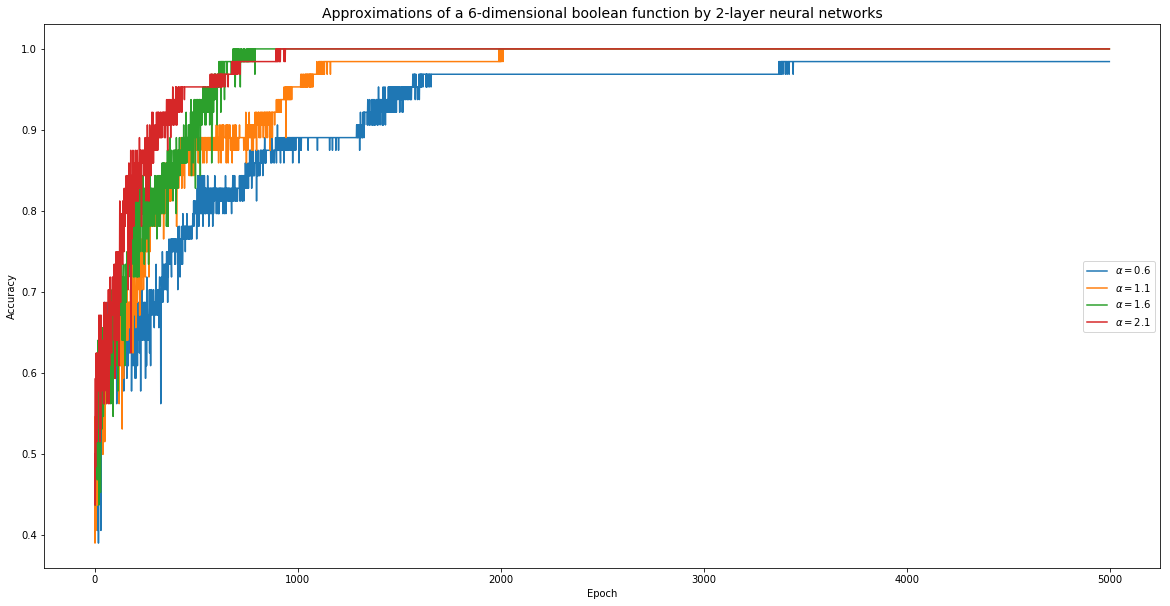

In [73]:
# figure size
plt.figure(figsize=(20,10))

# iterate through lists
for lst in acc_hist:
    plt.plot(lst)

# plot configurations
plt.title('Approximations of a 6-dimensional boolean function by 2-layer neural networks', fontsize = 14)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# legend
labels = [r"$\alpha = 0.6$", r"$\alpha = 1.1$", r"$\alpha = 1.6$", r"$\alpha = 2.1$"]
plt.legend(labels = labels, loc = "center right")


plt.show()

We continue with $n=7$.

#### $7$-dimensional boolean function
We generate the truth table and corresponding output data using the above ```boolean_func```.

In [8]:
X_7, y_7 = boolean_func(7)

We choose the network architecture, optimization configurations and training parameters to be similar as for $n=6$.

In [10]:
# network architecture
f7 = Sequential()
f7.add(Dense(6, activation = 'sigmoid', input_dim = 7))
f7.add(Dense(1, activation = 'sigmoid'))

# configures the model for training
sgd = SGD(lr = 1)
f7.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
f7.summary()

# training
f7.fit(X_7, y_7, epochs = 5000, verbose = 0)
cost, acc = f7.evaluate(X_7, y_7, verbose = 0)
print(f'cost: {cost}, acc: {acc * 100}%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6)                 48        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
cost: 0.14163844101130962, acc: 96.09375%


The above network, which was able to learn the 6-dimensional boolean function 100% accurate in 5.000 epoches, learns the above 7-dimensional boolean functions with 96.1% accuracy. The previous time, we succeeded to learn the boolean function for $n=6$ with extending the network we used for $n=5$ with two extra nodes in the hidden layer. So, let's try this again.

In [12]:
# network architecture
f7 = Sequential()
f7.add(Dense(8, activation = 'sigmoid', input_dim = 7))
f7.add(Dense(1, activation = 'sigmoid'))

# configures the model for training
sgd = SGD(lr = 1)
f7.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
f7.summary()

# training
f7.fit(X_7, y_7, epochs = 5000, verbose = 0)
cost, acc = f7.evaluate(X_7, y_7, verbose = 0)
print(f'cost: {cost}, acc: {acc * 100}%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8)                 64        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
cost: 0.04175688698887825, acc: 97.65625%


No, this seems not to work. The accuracy increased only slightly from 96.1% to 97.65%. Let's add two more nodes to the hidden layer. 

In [15]:
# network architecture
f7 = Sequential()
f7.add(Dense(10, activation = 'sigmoid', input_dim = 7))
f7.add(Dense(1, activation = 'sigmoid'))

# configures the model for training
sgd = SGD(lr = 1)
f7.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
f7.summary()

# training
f7.fit(X_7, y_7, epochs = 5000, verbose = 0)
cost, acc = f7.evaluate(X_7, y_7, verbose = 0)
print(f'cost: {cost}, acc: {acc * 100}%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 10)                80        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 11        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________
cost: 0.0041731264209374785, acc: 100.0%


That works! A 2-layer neural network with one layer of 10 hidden sigmoid neurons and one output layer with one sigmoid neuron learns the $7$-dimensional boolean function succesfully. We continue with $n=7$.

#### $8$-dimensional boolean function
We generate the truth table and corresponding output data using the above ```boolean_func```.

In [74]:
X_8, y_8 = boolean_func(8)

We choose the network architecture, optimization configurations and training parameters to be similar as for $n=7$.

In [75]:
# network architecture
f8 = Sequential()
f8.add(Dense(10, activation = 'sigmoid', input_dim = 8))
f8.add(Dense(1, activation = 'sigmoid'))

# configures the model for training
sgd = SGD(lr = 1)
f8.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
f8.summary()

# training
f8.fit(X_8, y_8, epochs = 5000, verbose = 0)
cost, acc = f8.evaluate(X_8, y_8, verbose = 0)
print(f'cost: {cost}, acc: {acc * 100}%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_113 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 11        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
cost: 0.07546000112779438, acc: 97.265625%


With the above network we reach 97.27% accuracy. Like we did before, we aim to achieve 100% accuracy by increase the amount of nodes in the hidden layer.

In [10]:
# network architecture
f8 = Sequential()
f8.add(Dense(12, activation = 'sigmoid', input_dim = 8))
f8.add(Dense(1, activation = 'sigmoid'))

# configures the model for training
sgd = SGD(lr = 1)
f8.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
f8.summary()

# training
f8.fit(X_8, y_8, epochs = 5000, verbose = 0)
cost, acc = f8.evaluate(X_8, y_8, verbose = 0)
print(f'cost: {cost}, acc: {acc * 100}%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
cost: 0.010415734781417996, acc: 100.0%


That works! We see that a 2-layer neural network with one hidden layer consisting of 12 sigmoid neurons and one output layer with one sigmoid neuron can learn a $8$-dimensional boolean function with 100% accuracy. 

We continue with $n=9$.

#### $9$-dimensional boolean function
We generate the truth table and corresponding output data using the above ```boolean_func```.

In [6]:
X_9, y_9 = boolean_func(9)

We choose the network architecture, optimization configurations and training parameters to be similar as for $n=8$.

In [7]:
# network architecture
f9 = Sequential()
f9.add(Dense(12, activation = 'sigmoid', input_dim = 9))
f9.add(Dense(1, activation = 'sigmoid'))

# configures the model for training
sgd = SGD(lr = 1)
f9.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
f9.summary()

# training
f9.fit(X_9, y_9, epochs = 5000, verbose = 0)
cost, acc = f9.evaluate(X_9, y_9, verbose = 0)
print(f'cost: {cost}, acc: {acc * 100}%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                120       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________
cost: 0.29698003362864256, acc: 90.234375%


The network we used to achieve 100% accuracy on learning a $8$-dimensional boolean function, learns a $9$-dimensional boolean function with 90.23% accuracy. Let's increase the amount of neurons in the hidden layer to 16.

In [8]:
# network architecture
f9 = Sequential()
f9.add(Dense(16, activation = 'sigmoid', input_dim = 9))
f9.add(Dense(1, activation = 'sigmoid'))

# configures the model for training
sgd = SGD(lr = 1)
f9.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
f9.summary()

# training
f9.fit(X_9, y_9, epochs = 5000, verbose = 0)
cost, acc = f9.evaluate(X_9, y_9, verbose = 0)
print(f'cost: {cost}, acc: {acc * 100}%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                160       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________
cost: 0.07264171191491187, acc: 98.046875%


This gives us 98.04% accuracy. What happens if we iterate through different learning rates, i.e. $\alpha \in [0.6, 1.1, 1.6, 2.1]$? 

In [10]:
alphas = np.linspace(0.6,2.1,4)
acc_hist = []

for alpha in alphas:
    print("alpha:", alpha)
    
    # network architecture
    f9 = Sequential()
    f9.add(Dense(16, activation = 'sigmoid', input_dim = 9))
    f9.add(Dense(1, activation = 'sigmoid'))

    # configures the model for training
    sgd = SGD(lr = alpha)
    f9.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])

    # training
    f9.fit(X_9, y_9, epochs = 5000, verbose = 0)
    cost, acc = f9.evaluate(X_9, y_9, verbose = 0)
    print(f'cost: {cost}, acc: {acc * 100}%')

alpha: 0.6
cost: 0.12726512167137116, acc: 96.2890625%
alpha: 1.1
cost: 0.05832864867988974, acc: 99.0234375%
alpha: 1.6
cost: 0.11075781576801091, acc: 94.53125%
alpha: 2.1
cost: 0.11757467483403161, acc: 94.921875%


For all learning rates, especially for $\alpha = 1.1$,  we get close but none of them reaches 100% accuracy. Next, we iterate through both, different learning rates (in the above grid) and through different number of nodes in the hidden layer, i.e. 8, 16 and 32 nodes.

In [11]:
nodes_hidden_layer = [2**a for a in range(3,6)]
alphas = np.linspace(0.6,2.1,4)
acc_hist = []

for n_nodes in nodes_hidden_layer:
    print("n_nodes:", n_nodes)
    
    for alpha in alphas:
        print("alpha:", alpha)

        # network architecture
        f9 = Sequential()
        f9.add(Dense(16, activation = 'sigmoid', input_dim = 9))
        f9.add(Dense(1, activation = 'sigmoid'))

        # configures the model for training
        sgd = SGD(lr = alpha)
        f9.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])

        # training
        f9.fit(X_9, y_9, epochs = 5000, verbose = 0)
        cost, acc = f9.evaluate(X_9, y_9, verbose = 0)
        print(f'cost: {cost}, acc: {acc * 100}%')

n_nodes: 8
alpha: 0.6
cost: 0.06784065085230395, acc: 98.2421875%
alpha: 1.1
cost: 0.0789033817127347, acc: 97.4609375%
alpha: 1.6
cost: 0.16769669065251946, acc: 95.703125%
alpha: 2.1
cost: 0.1529525590594858, acc: 94.7265625%
n_nodes: 16
alpha: 0.6
cost: 0.13786259025800973, acc: 95.5078125%
alpha: 1.1
cost: 0.14777164289262146, acc: 94.7265625%
alpha: 1.6
cost: 0.19517893064767122, acc: 91.796875%
alpha: 2.1
cost: 0.10210577090037987, acc: 96.6796875%
n_nodes: 32
alpha: 0.6
cost: 0.08645635191351175, acc: 97.65625%
alpha: 1.1
cost: 0.05574441410135478, acc: 98.4375%
alpha: 1.6
cost: 0.11974482116056606, acc: 94.3359375%
alpha: 2.1
cost: 0.16008330089971423, acc: 94.53125%


None of the above combinations reaches 100% accuracy and even none of them reaches a better accuracy rate than we saw before (99.02%). Since we are still creating 2-layer neural networks, let's see what happens if we add an extra (hidden) layer of 8 sigmoid nodes to the existing hidden layer with 16 hidden sigmoid nodes. 

In [11]:
alphas = np.linspace(0.6,2.1,4)
acc_hist = []
    
for alpha in alphas:
    print("alpha:", alpha)

    # network architecture
    f9 = Sequential()
    f9.add(Dense(16, activation = 'sigmoid', input_dim = 9))
    f9.add(Dense(8, activation = 'sigmoid'))
    f9.add(Dense(1, activation = 'sigmoid'))

    # configures the model for training
    sgd = SGD(lr = alpha)
    f9.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])

    # training
    f9.fit(X_9, y_9, epochs = 5000, verbose = 0)
    cost, acc = f9.evaluate(X_9, y_9, verbose = 0)
    print(f'cost: {cost}, acc: {acc * 100}%')

alpha: 0.6
cost: 0.0034206090567749925, acc: 100.0%
alpha: 1.1
cost: 0.696610726416111, acc: 50.0%
alpha: 1.6
cost: 1.254307359457016, acc: 50.0%
alpha: 2.1
cost: 1.9814178496599197, acc: 50.0%


We see that this $3$-layer neural network is able to learn a $9$-dimensional boolean function.

We continue with $n = 10$.

#### $10$-dimensional boolean function
We generate the truth table and corresponding output data using the above ```boolean_func```.

In [3]:
X_10, y_10 = boolean_func(10)
X_10, y_10

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [1, 1, 1, ..., 1, 0, 1],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1]]), array([1, 0, 0, ..., 1, 1, 1]))

In the meantime, we are working with a truth table that consists of 1024 rows. 

In [4]:
print(X_10.shape)
print(y_10.shape)

(1024, 10)
(1024,)


We directly start with iterating through learning rates $\alpha \in [0.01, 1, 5, 10, 15]$ and through $4,8,16$ and $32$ number of sigmoid nodes in 3-hidden layers. Note that at the end of all networks still output layer with one sigmoid neuron exists.

In [6]:
nodes_hidden_layer = [2**a for a in range(2,7)]
alphas = [0.01, 1, 5, 10, 15]
acc_hist = []

for n_nodes in nodes_hidden_layer:
    print("n_nodes:", n_nodes)
    
    for alpha in alphas:
        print("alpha:", alpha)
        
        # network architecture
        f10 = Sequential()
        f10.add(Dense(n_nodes, activation='sigmoid', input_dim = 10))
        f10.add(Dense(n_nodes, activation='sigmoid'))
        f10.add(Dense(n_nodes, activation='sigmoid'))
        f10.add(Dense(1, activation='sigmoid'))

        # configures the model for training
        sgd = SGD(lr = alpha)
        f10.compile(loss='binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])

        # training
        history = f10.fit(X_10, y_10, epochs = 5000, verbose = 0)
        acc_hist.append(history.history['acc'])
        cost, acc = f10.evaluate(X_10, y_10, verbose = 0)
        print(f'cost: {cost}, acc: {acc * 100}%')

n_nodes: 4
alpha: 0.01
cost: 0.692974267527461, acc: 52.734375%
alpha: 1
cost: 0.5971913812682033, acc: 57.8125%
alpha: 5
cost: 0.7027502804994583, acc: 50.5859375%
alpha: 10
cost: 0.6984566356986761, acc: 61.328125%
alpha: 15
cost: 0.6993647608906031, acc: 50.0%
n_nodes: 8
alpha: 0.01
cost: 0.6926170662045479, acc: 53.125%
alpha: 1
cost: 0.33678991394117475, acc: 84.27734375%
alpha: 5
cost: 0.6331344107165933, acc: 61.71875%
alpha: 10
cost: 0.6148808486759663, acc: 60.7421875%
alpha: 15
cost: 2.010170739144087, acc: 50.09765625%
n_nodes: 16
alpha: 0.01
cost: 0.690402626991272, acc: 53.41796875%
alpha: 1
cost: 0.05227931309491396, acc: 98.33984375%
alpha: 5
cost: 0.3532833606004715, acc: 85.44921875%
alpha: 10
cost: 0.5066559901461005, acc: 76.85546875%
alpha: 15
cost: 0.9543400723487139, acc: 50.87890625%
n_nodes: 32
alpha: 0.01
cost: 0.6913351807743311, acc: 53.80859375%
alpha: 1
cost: 7.164595086806003e-05, acc: 100.0%
alpha: 5
cost: 0.697993928566575, acc: 50.0%
alpha: 10
cost: 8.0

For one combination ($\alpha = 1$ and 3 hidden layers with $32$ sigmoid neurons) the network achieves 100% accuracy. 

During the above search, we kept track of the accuracy metrics of the networks. We plot the accuracy of the above networks versus the number of epoches below.

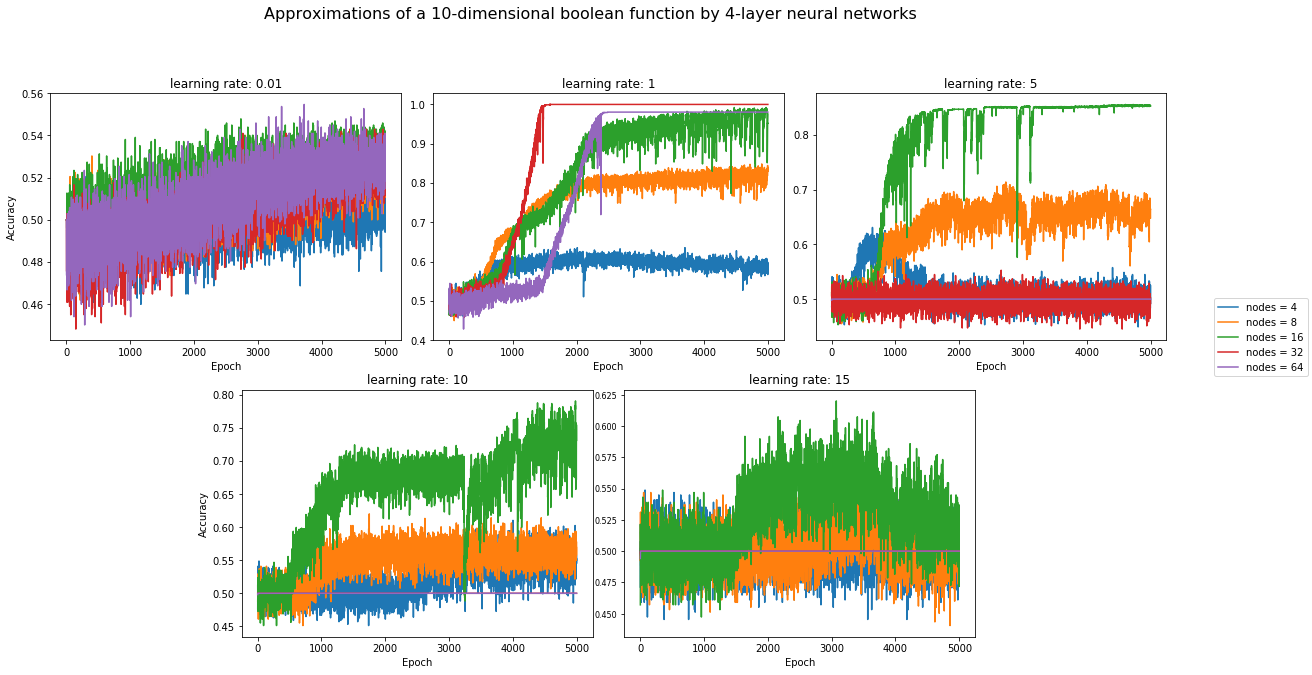

In [50]:
from matplotlib.ticker import FormatStrFormatter

# subplot grid + title
fig, ax = plt.subplots(5, 1, figsize = (20, 10))
ax[0] = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax[1] = plt.subplot2grid((2,6), (0,2), colspan=2)
ax[2] = plt.subplot2grid((2,6), (0,4), colspan=2)
ax[3] = plt.subplot2grid((2,6), (1,1), colspan=2)
ax[4] = plt.subplot2grid((2,6), (1,3), colspan=2)

# plot accuracy
for i in range(0,25): 
        j = i % 5
        ax[j].plot(acc_hist[i])
#         ax[j].plot(acc_hist_smooth[i])
        
# plot subtitles
for k in range(1,5):
    ax[0].set_title("learning rate: %.2f" %alphas[0])
    ax[0].set_xlabel('Epoch')
    ax[k].set_title("learning rate: %i" %alphas[k])
    ax[k].set_xlabel('Epoch')
    
# plot labels on axis
for l in [0,3]:
    ax[l].set_ylabel('Accuracy')

# plot specifications
fig.suptitle("Approximations of a 10-dimensional boolean function by 4-layer neural networks", fontsize = 16, y = 1)
ax[4].yaxis.set_tick_params(labelsize = 8)

# legend
labels = ["nodes = 4", "nodes = 8", "nodes = 16", "nodes = 32", "nodes = 64"]
fig.legend([ax[0],ax[1],ax[2],ax[3],ax[4]], labels = labels, loc = "center right")

plt.show()

We see that a learning rate $\alpha = 1$ works by far the best. Besides, we see that a lower amount of neurons (nodes) in the hidden layer tend to perform worse than networks with more nodes in the hidden layers of the network.

For now, we stop at $n=10$.

### 7. Conclusion
We proved that every $n$-dimensional boolean function can be represented as a composition of AND, OR and NOT gates. We have shown that each of those logic gates can be learned by perceptrons, which in its turn can be approximated perfectly by sigmoid neurons. Based on this theoretical foundation, we learned how to build a network of sigmoid neurons that are trained by forward, backward propagation and gradient descent optimization techniques. We build those neural networks from scratch in plain numpy code. In addition, we elaborated on generic techniques like *direction changes* to find effective learning rates for non-linear optimization methods. With the help of Keras we built higher dimensional boolean function. We saw that for all $n = 1, \ldots , 10$, $n$-dimensional boolean function can be approximated 100% accurate by simple neural networks. We devised neural networks consisting of 2 to 4-hidden layers, containing 4 up to 64 sigmoid neurons each, to learn boolean functions. We found that the most effective networks use a learning rate that is close to $\alpha = 1$.

*To answer the main question: we have shown that $n$-dimensional boolean functions up to $n=10$ can be approximated 100% accurate quite easily by simple neural networks.*

### 8. Discussion
Taking into consideration the broad range of topics covered in the course, this project might seem to be rather basic. However, in this project I aimed to focus on a more theoretical perspective of deep learning than common subjects in, for example, image recognition do. For this reason, I decided to build neural networks from the bottom up in plain numpy code instead of using sophisticated state-of-the-art techniques without understanding what exactly is going on. By avoiding this common practice in deep learning, to use those kind of black-box techniques, I tried to show my profound understanding of the most basic concepts. Though, learning a $10$-dimensional boolean function existing of $1024 \times 10$ input data is somewhere in between learning $64 \times 64$ and $128 \times 128$ black-white pixel sized image. Bearing in mind the accuracy of techniques in deep learning on far higher dimensional image recognition problems, we could have included more advanced $n$-dimensional boolean function learning problems in this project, i.e. we could have used more advanced techniques for learning boolean function with $n > 100$ or even $n > 1000$.